In [1]:
%matplotlib inline
from __future__ import division
import scipy
from scipy.stats import binom, uniform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from math import sqrt, pi, exp, log

plt.rcParams['figure.figsize'] = (10.0, 8.0)
T = 1000
scale=1
colors = cm.rainbow(np.linspace(0, 1, 6))
scipy.set_printoptions(precision = 4, suppress = True)
V = ['0','1','2','3','4','5']
Q = ['-1','0','1']
M = 5

/home/saket/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def b(x, q):
    p = binom.pmf(x, M, 0.5+0.25*q, loc=0)
    return p

def Yt(q):
    q=float(q)
    return str(binom.rvs(M, 0.5+0.25*q))


def YtDiscrete(q):
    values = ['-1', '0', '1']
    probabilities = [0.005, 0.005, 0.005]
    for i, x in enumerate(values):
        if x==q:
            probabilities[i] = 0.990            
    return np.random.choice(values, p=probabilities)

def alpha_pass2(O,A,B,PI):
    alpha = [{} for t in range(0,T)]
    c = [0 for t in range(0,T)]
    alpha[0] = {i: PI[i]*B[i][O[0]] for i in Q}
    c[0] = sum(alpha[0].values())    
    c[0]=1/c[0]
    alpha[0].update((x, y*c[0]) for x, y in alpha[0].items())
    for t in range(1,T):
        for i in Q:
            alpha[t][i] = sum([A[j][i]*alpha[t-1][i] for j in Q])                
            alpha[t][i] = alpha[t][i]*B[i][yt[t]]
            c[t] = c[t]+alpha[t][i]
        c[t]=1/c[t]
        alpha[t].update((x, y*c[t]) for x, y in alpha[t].items())
    return {'alpha': alpha, 'c': c}

def beta_pass2(O,A,B,c):
    beta = [{} for t in range(0,T)]
    beta[T-1] = {i: c[T-1] for i in Q} 
    
    for t in range(T-2,-1,-1):
        for i in Q:
            beta[t][i] = sum([A[i][j] *B[j][O[t+1]] *beta[t+1][j] for j in Q])
            beta[t][i] = c[t]*beta[t][i]
        
    return beta

def gamma_pass2(O, A, B, c, al, be):
    gammaij = [{} for t in range(0,T)]
    gamma = [{} for t in range(0,T)]
    for t in range(0,T-1):
        denom = 0
        for i in Q:
            for j in Q:
                denom = denom +  al[t][i]*A[i][j]*B[j][O[t+1]]*be[t+1][j]
                
        for i in Q:
            gammaij[t][i] =  {}
            for j in Q:
                gammaij[t][i][j] = al[t][i]*A[i][j]*B[j][O[t+1]]*be[t+1][j]/denom
            gamma[t][i] = sum(gammaij[t][i].values())
            
    denom = sum(alpha[T-1].values())
    for i in Q:
            gamma[T-1][i] = al[T-1][i]/denom
    

    return {'gamma': gamma, 'gammaij': gammaij}

def viterbi(yt,PI,A,B):
    delta = [{} for t in range(0,T)]
    path = {}
    for q in Q:
        delta[0][q] = log(PI[q])+log(B[q][yt[0]]) 
        path[q] = [q]
    #print path
    for t in range(1,T):
        tempath = {}
        for q in Q:
            (Z, state) =  max(( delta[t-1][x] +log(B[q][yt[t]]) + log(A[x][q]),x) for x in Q)
            delta[t][q] = Z
            #print(q,state)
            tempath[q] = path[state]+[q]
        path = tempath
        #print path
    #print(delta)
    (p, state) = max((delta[T-1][q], q) for q in Q)
    #print(p)
    return path[state],delta


def run_hmm(A, PI, discrete=False):
    states = []
    probs = []
    if discrete:
        Y = YtDiscrete
    else:
        Y = Yt
    for key,value in PI.iteritems():
        states.append(key)
        probs.append(value)
    starting_state = np.random.choice(states,p=probs)
    prev_state = starting_state
    xt = [prev_state]
    yt = [Y(prev_state)]
    #print(xt,yt)
    for t in range(1,T):
        state_tpm = A[xt[t-1]]
        row_states = []
        row_probs = []
        for key,value in state_tpm.iteritems():
            row_states.append(key)
            row_probs.append(value)
        next_state = np.random.choice(row_states, p=row_probs)
        xt.append(next_state)
        yt.append(Y(next_state)) 
    return {'xt': xt, 'yt': yt}


In [3]:
V = ['0','1','2','3','4','5']
Q = ['-1','0','1']
B0 = {}
for q in Q:
    B0[q] = {}
    for v in V:
        vi = int(v)
        B0[q][v] = b(vi, int(q))

A0 = {'-1': {'-1': 0.990 , '0': 0.005, '1': 0.005} , 
     '0': {'-1': 0.005 , '0': 0.990, '1': 0.005} , 
     '1': {'-1': 0.005 , '0': 0.005, '1': 0.990}}
PI0 = {'-1':1/3,'0':1/3,'1':1/3}


## Part (a) [Check for discrete distro]

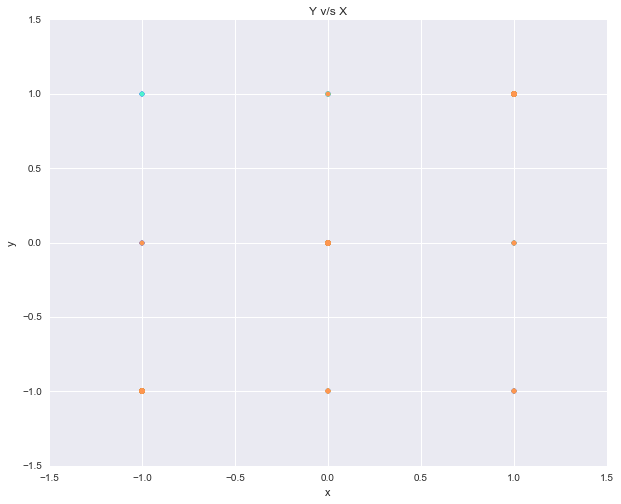

In [4]:
V = Q
B0 = A0
np.random.seed(100)
for i in range(0,5):
    d = run_hmm(A0, PI0, discrete=True)
    xt = d['xt']
    yt = d['yt']
    plt.scatter(xt, yt, color=colors[i])
plt.title('Y v/s X')
plt.xlabel('x')
plt.ylabel('y')

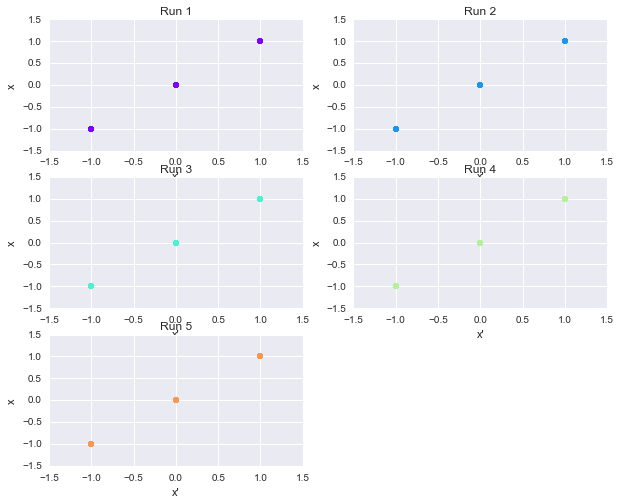

In [5]:
fig = plt.figure()
np.random.seed(100)
for i in range(0,5):
    d = run_hmm(A0, PI0, discrete=True)
    ax = fig.add_subplot(3,2,i+1)
    xt = d['xt']
    yt = d['yt']
    xtp, delta = viterbi(yt,PI0,A0,B0)
    plt.scatter(xtp, xt, color=colors[i])
    plt.title('Run {}'.format(i+1))
    plt.xlabel("x'")
    plt.ylabel('x')

## Part (a) [Actual]

In [6]:
V = ['0','1','2','3','4','5']
Q = ['-1','0','1']
B0 = {}
for q in Q:
    B0[q] = {}
    for v in V:
        vi = int(v)
        B0[q][v] = b(vi, int(q))

A0 = {'-1': {'-1': 0.990 , '0': 0.005, '1': 0.005} , 
     '0': {'-1': 0.005 , '0': 0.990, '1': 0.005} , 
     '1': {'-1': 0.005 , '0': 0.005, '1': 0.990}}
PI0 = {'-1':1/3,'0':1/3,'1':1/3}


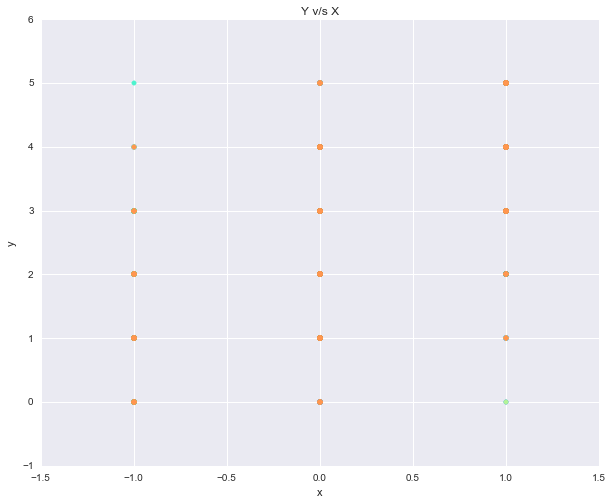

In [7]:
np.random.seed(100)
for i in range(0,5):
    d = run_hmm(A0, PI0, discrete=False)
    xt = d['xt']
    yt = d['yt']
    plt.scatter(xt, yt, color=colors[i])
plt.title('Y v/s X')
plt.xlabel('x')
plt.ylabel('y')

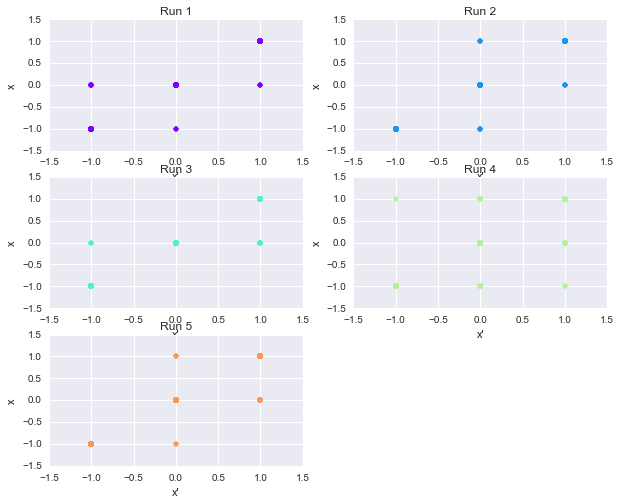

In [8]:
fig = plt.figure()
np.random.seed(100)
for i in range(0,5):
    d = run_hmm(A0, PI0, discrete=False)
    ax = fig.add_subplot(3,2,i+1)
    xt = d['xt']
    yt = d['yt']
    xtp, delta = viterbi(yt,PI0,A0,B0)
    plt.scatter(xtp, xt, color=colors[i])
    plt.title('Run {}'.format(i+1))
    plt.xlabel("x'")
    plt.ylabel('x')

## Part (b)

In [9]:
np.random.seed(100)
for i in range(0,6):
    d = run_hmm(A0, PI0)
    xt = d['xt']
    yt = d['yt']
    alp = alpha_pass2(yt,A0,B0,PI0)
    alpha = alp['alpha']
    c = alp['c']
    sumlogc = sum([log(x) for x in c])
    prob = (-sumlogc)
    print('logProb = {}'.format(prob))

logProb = -1846.46897755
logProb = -1889.32552012
logProb = -1861.71821553
logProb = -1730.39971565
logProb = -1676.97025488
logProb = -1870.45855227


# Part (c)

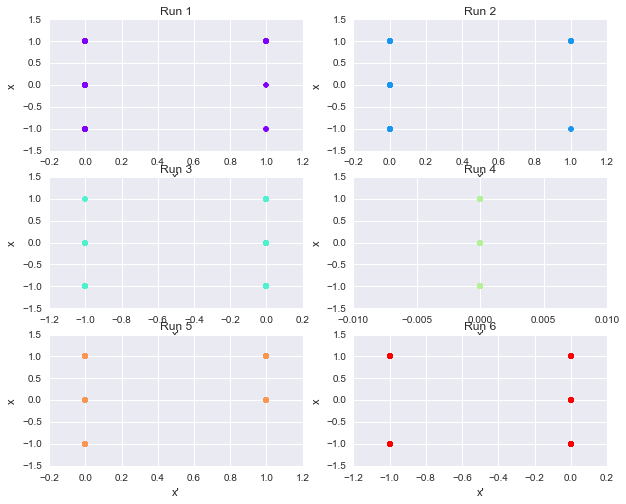

In [10]:
import operator
fig = plt.figure()

np.random.seed(100)
for i in range(0,6):
    d = run_hmm(A0, PI0)
    xt = d['xt']
    yt = d['yt']
    alp = alpha_pass2(yt,A0,B0,PI0)
    alpha = alp['alpha']
    c = alp['c']
    sumlogc = sum([log(x) for x in c])
    prob = (-sumlogc)
    beta = beta_pass2(yt,A0,B0,c)
    gamm = gamma_pass2(yt, A0, B0, c, alpha, beta)
    gamma = gamm['gamma']
    xtp = []
    for t in range(0,T):
        stats = gamma[t]
        ml = max(stats.iteritems(), key=operator.itemgetter(1))[0]
        xtp.append(ml)
    ax = fig.add_subplot(3,2,i+1)    
    plt.scatter(xtp, xt, color=colors[i])
    plt.title('Run {}'.format(i+1))
    plt.xlabel("x'")
    plt.ylabel('x')


# Part (e)

In [11]:
def restimate(gamma, gammaij, c ):
    pi1 = {i: gamma[0][i] for i in Q}
    #print('PI', pi1)

    Aest = {str(k):{} for k in Q}

    for i in Q:
        for j in Q:
            num = 0
            denom = 0
            for t in range(0,T-1):
                num = num + gammaij[t][i][j]
                denom = denom+ gamma[t][i]
            Aest[i][j] = num/denom
    Best = {k: {} for k in Q}
    
    for i in Q:
        for j in V:
            num = 0
            denom = 0
            for t in range(0,T):
                if yt[t] == j:
                    num = num + gamma[t][i]
                denom = denom + gamma[t][i]
            Best[i][j] = num/denom
    
    logP = -sum(log(x) for x in c)        
    return {'A': Aest, 'B': Best, 'logP': logP, 'PI': pi1}

In [12]:
np.random.seed(100)
d = run_hmm(A0, PI0)
xt = d['xt']
yt = d['yt']

In [33]:
notconverge = True
oldlogP = -10e6
iters = 0
Aest = {'-1': {'-1': 7/9 , '0': 1/9, '1': 1/9} , 
     '0': {'-1': 1/9 , '0': 7/9, '1': 1/9} , 
     '1': {'-1': 1/9 , '0': 1/9, '1': 7/9}}
PIest = {'-1':1/3,'0':1/3,'1':1/3}
Best = {}
for q in Q:
    Best[q] = {}
    for v in V:
        vi = int(v)
        Best[q][v] = 1/6

while notconverge and iters<300:
    iters +=1
    alp = alpha_pass2(yt,Aest,Best,PIest)
    alpha = alp['alpha']
    c = alp['c']
    #print(alpha)
    beta = beta_pass2(yt,Aest,Best,c)
    gamm = gamma_pass2(yt, Aest, Best, c, alpha, beta)
    gamma = gamm['gamma']
    gammaij = gamm['gammaij']
    restimated = restimate(gamma, gammaij, c )
    Aest = restimated['A']
    Best = restimated['B']
    PIest = restimated['PI']
    logP = restimated['logP']
    print(iters, logP)
    if oldlogP < logP and iters<1000:
        oldlogP = logP

    else:
        print iters
        print('A', Aest)    
        print('B', Best)
        print('PI', PIest)
        break



    

(1, -1791.7594692280547)
(2, -1730.5070204876558)
(3, -1730.5070204876556)
(4, -1730.5070204876754)
4
('A', {'1': {'1': 0.7777777777777846, '0': 0.11111111111110795, '-1': 0.11111111111110795}, '0': {'1': 0.11111111111111628, '0': 0.7777777777777738, '-1': 0.11111111111111012}, '-1': {'1': 0.11111111111111628, '0': 0.11111111111111012, '-1': 0.7777777777777738}})
('B', {'1': {'1': 0.1709999999999365, '0': 0.08699999999999375, '3': 0.236999999999992, '2': 0.20599999999997556, '5': 0.09700000000004706, '4': 0.202000000000056}, '0': {'1': 0.17100000000003204, '0': 0.08700000000000316, '3': 0.23700000000000407, '2': 0.20600000000001234, '5': 0.09699999999997651, '4': 0.20199999999997204}, '-1': {'1': 0.17100000000003204, '0': 0.08700000000000316, '3': 0.23700000000000407, '2': 0.20600000000001234, '5': 0.09699999999997651, '4': 0.2019999999999721}})
('PI', {'1': 0.3333333333333323, '0': 0.3333333333333339, '-1': 0.3333333333333339})
